In [7]:
import glob
import os
import random
import xarray as xr
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks, Input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

nb='/home/afahad/nb/subgrid_tend/model/'
# Enable GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"Using {len(gpus)} GPU(s)")
else:
    print("No GPUs found, using CPU.")

# Multi-GPU strategy
strategy = tf.distribute.MirroredStrategy()
print(f"Replicas: {strategy.num_replicas_in_sync}")

# Pearson correlation metric
def correlation_metric(y_true, y_pred):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    mean_true = tf.reduce_mean(y_true_flat)
    mean_pred = tf.reduce_mean(y_pred_flat)
    cov = tf.reduce_mean((y_true_flat - mean_true) * (y_pred_flat - mean_pred))
    std_true = tf.sqrt(tf.reduce_mean((y_true_flat - mean_true)**2))
    std_pred = tf.sqrt(tf.reduce_mean((y_pred_flat - mean_pred)**2))
    return cov / (std_true * std_pred + tf.keras.backend.epsilon())

Using 1 GPU(s)
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Replicas: 1


In [8]:
import numpy as np
import xarray as xr

def reshape_to_blocks(var, face_y_chunk=30, x_chunk=15):
    """
    Reshape a DataArray with dims (time, lev, face, y, x) into
    (block, face_y, x, lev), where:
      block = time * (face*y // face_y_chunk) * (x // x_chunk)
      face_y = face_y_chunk
      x      = x_chunk
      lev    preserved as channel dim at the end

    Parameters
    ----------
    var : xarray.DataArray
        Input array, must have dims ("time","lev","face","y","x").
    face_y_chunk : int
        Size of each chunk along the stacked (face,y) dimension.
    x_chunk : int
        Size of each chunk along the x dimension.

    Returns
    -------
    xarray.DataArray
        4-D array with dims ("block","face_y","x","lev").
    """
    # 1) stack face & y, and bring dims into a known order
    X = var.stack(face_y=("face","y")).transpose("time","lev","face_y","x")

    # 2) compute how many chunks along face_y and x
    n_fy_chunks = X.sizes["face_y"] // face_y_chunk
    n_x_chunks  = X.sizes["x"]      // x_chunk

    # 3) reshape into 6-D: (time, lev, nchunk, face_y, nchunk_x, x)
    arr = X.data.reshape(
        X.sizes["time"],
        X.sizes["lev"],
        n_fy_chunks,    face_y_chunk,
        n_x_chunks,     x_chunk
    )

    # 4) wrap back into xarray and assign coords
    Y = xr.DataArray(
        arr,
        dims=("time","lev","nchunk","face_y","nchunk_x","x"),
        coords={
            "time":     X.coords["time"],
            "lev":      X.coords["lev"],
            "nchunk":   np.arange(n_fy_chunks),
            "face_y":   np.arange(face_y_chunk),
            "nchunk_x": np.arange(n_x_chunks),
            "x":        np.arange(x_chunk),
        }
    )

    # 5) move (time, nchunk, nchunk_x) into a single "block" axis,
    #    leave lev till last so it can act as channels
    result = (
        Y
        .transpose("time","nchunk","nchunk_x","face_y","x","lev")
        .stack(block=("time","nchunk","nchunk_x"))
        .transpose("block","face_y","x","lev")
    )

    return result

In [10]:
ds=xr.open_mfdataset('/home/afahad/nb/subgrid_tend/6km/Qtrain_*202001*.nc4')
n=ds.dQV.shape[0]; nl=ds.dQV.shape[1]; nf=ds.dQV.shape[2]; nx=ds.dQV.shape[3]; ny=ds.dQV.shape[4]
#X= reshape_to_blocks(ds.dT, face_y_chunk=30, x_chunk=15)
#Y= reshape_to_blocks(ds.subT, face_y_chunk=30, x_chunk=15)

In [11]:
X1=ds.dQV
X2=ds.QV
Y=ds.subQV

In [12]:
# Define the coordinate values
face_coord = np.arange(1, 7)           # [1, 2, 3, 4, 5, 6]
y_coord = np.arange(90)               # [0, 1, …, 89]
x_coord = np.arange(90)               # [0, 1, …, 89]
n=len(Y)
# Create a (6,1,1) array of face values, then broadcast to (6,90,90)
face = face_coord[ None,:, None, None, None] * np.ones((n,6, 90, 90, 52))
xdata = x_coord[ None,None, None, :, None] * np.ones((n,6, 90, 90, 52))
ydata = y_coord[ None,None, :, None, None] * np.ones((n,6, 90, 90, 52))

face=np.reshape(face,(n*nf*ny*nx,nl))
xdata=np.reshape(xdata,(n*nf*ny*nx,nl))
ydata=np.reshape(ydata,(n*nf*ny*nx,nl))

face_min, face_max   = face.min(),   face.max()
xdata_min, xdata_max = xdata.min(), xdata.max()
ydata_min, ydata_max = ydata.min(), ydata.max()

# 2) min–max normalize into [0,1], overwriting the originals
face  = (face  - face_min)  / (face_max  - face_min)
xdata = (xdata - xdata_min) / (xdata_max - xdata_min)
ydata = (ydata - ydata_min) / (ydata_max - ydata_min)

In [13]:
# compute global min & max
X1_min, X1_max = X1.min(), X1.max()
X2_min, X2_max = X2.min(), X2.max()
Y_min, Y_max = Y.min(), Y.max()

# min–max normalize into [0,1]
Xn1 = (X1 - X1_min) / (X1_max - X1_min)
Xn2 = (X2 - X2_min) / (X2_max - X2_min)
Yn = (Y - Y_min) / (Y_max - Y_min)

In [14]:
Xn=xr.concat([Xn1,Xn2],dim='lev')

In [15]:
Xn=(Xn
    .stack(face_y=("face","y"))
    .transpose("time","face_y","x","lev")
)
Yn=(Yn
    .stack(face_y=("face","y"))
    .transpose("time","face_y","x","lev")
)

In [16]:
Xn=np.reshape(Xn.data,(n*nf*ny*nx,nl*2))
Yn=np.reshape(Yn.data,(n*nf*ny*nx,nl))

In [17]:
Xn=np.concatenate((Xn,face,xdata, ydata),axis=-1) 

In [18]:
Xn=Xn.compute()
Yn=Yn.compute()

In [19]:
n = len(Xn); blocks = np.arange(n)

# split 80% train / 20% test
train_idx, test_idx = train_test_split(
    blocks,
    train_size=0.8,
    random_state=42,   # for reproducibility
    shuffle=True)

# select your splits
# X_train = Xn[train_idx,:,:,:]; X_test  = Xn[test_idx,:,:,:]
# Y_train = Yn[train_idx,:,:,:]; Y_test  = Yn[test_idx,:,:,:]
X_train = Xn[train_idx,:]; X_test  = Xn[test_idx,:]
Y_train = Yn[train_idx,:]; Y_test  = Yn[test_idx,:]

In [20]:
del Xn, Yn

In [21]:
print("X_train:", X_train.shape, "Y_train:", Y_train.shape)
print("   min/max X:", X_train.min().item(), X_train.max().item())
print("   unique X values:", np.unique(X_train[:10,1]))

print("   min/max Y:", Y_train.min().item(), Y_train.max().item())
print("   unique Y values:", np.unique(Y_train[:10,1]))

X_train: (7542720, 260) Y_train: (7542720, 52)
   min/max X: 0.0 1.0
   unique X values: [0.48529786 0.48529804 0.48529807 0.48529828 0.48529831 0.48529851
 0.48529857 0.4852989  0.48529926]
   min/max Y: 0.0 1.0
   unique Y values: [0.498329   0.49834374 0.49835837 0.4983673  0.49836785 0.49837062
 0.4983771  0.49837995 0.4983872  0.4983893 ]


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

# number of input (and output) features
n_features = 52

# Learning-rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
# with strategy.scope():
    # Build the MLP
model = models.Sequential([
        # Input layer
        layers.Input(shape=(n_features*5,)),
    
        # Hidden layers
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
    
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
    
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
    
        layers.Dropout(0.2),
    
        # Final output layer (linear activation for regression)
        layers.Dense(n_features, activation="linear"),
    ])
    
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               33408     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [23]:
batch_size = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = (
    tf.data.Dataset
      .from_tensor_slices((X_train, Y_train))
      .shuffle(buffer_size=10_000, seed=42)   # shuffle your blocks
      .batch(batch_size)
      .prefetch(AUTOTUNE)
)


test_ds = (
    tf.data.Dataset
      .from_tensor_slices((X_test, Y_test))
      .shuffle(buffer_size=10_000, seed=42)   # shuffle your blocks
      .batch(batch_size)
      .prefetch(AUTOTUNE)
)

In [24]:
checkpoint_cb = callbacks.ModelCheckpoint(
    nb+'cnn2d_subgrid_best.h5', save_best_only=True,
    monitor='val_loss', mode='min', save_weights_only=False
)



In [25]:
ehistory = model.fit(
        train_ds,
        validation_data=test_ds,
        epochs=20,
        callbacks=[checkpoint_cb],
        verbose=1
    )

Epoch 1/20
235710/235710 [==============================] - 490s 2ms/step - loss: 0.0052 - mae: 0.0183 - val_loss: 6.5376e-04 - val_mae: 0.0102
Epoch 2/20
235710/235710 [==============================] - 490s 2ms/step - loss: 6.5269e-04 - mae: 0.0102 - val_loss: 6.5373e-04 - val_mae: 0.0102
Epoch 3/20
235710/235710 [==============================] - 491s 2ms/step - loss: 6.5269e-04 - mae: 0.0102 - val_loss: 6.5375e-04 - val_mae: 0.0102
Epoch 4/20
235710/235710 [==============================] - 491s 2ms/step - loss: 6.5270e-04 - mae: 0.0102 - val_loss: 6.5373e-04 - val_mae: 0.0102
Epoch 5/20
235710/235710 [==============================] - 491s 2ms/step - loss: 6.5270e-04 - mae: 0.0102 - val_loss: 6.5375e-04 - val_mae: 0.0102
Epoch 6/20
235710/235710 [==============================] - 492s 2ms/step - loss: 6.5270e-04 - mae: 0.0102 - val_loss: 6.5372e-04 - val_mae: 0.0102
Epoch 7/20
235710/235710 [==============================] - 492s 2ms/step - loss: 6.5270e-04 - mae: 0.0102 - val_los

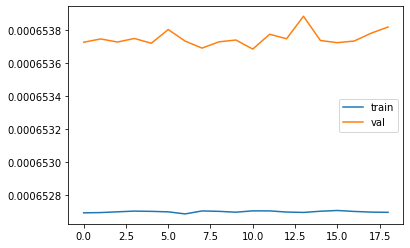

In [31]:
t=1
plt.figure(); plt.plot(ehistory.history['loss'][t:], label='train'); plt.plot(ehistory.history['val_loss'][t:], label='val'); plt.legend(); plt.show()


In [27]:
y_pred = model.predict(X_test[0:1,:])
test=Y_test[0:1,:]

In [28]:
y_pred=(y_pred * (Y_max.data - Y_min.data) + Y_min.data)
test=(test * (Y_max.data - Y_min.data) + Y_min.data)

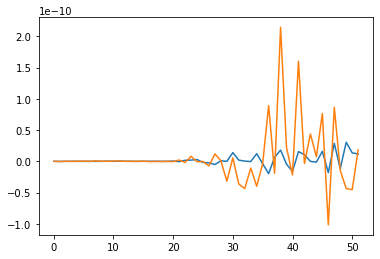

In [29]:
plt.plot(y_pred[0,:])
plt.plot(test[0,:])